# Fake news detection

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

## Read datasets

In [33]:
fake = pd.read_csv("data/Fake.csv")
true = pd.read_csv("data/True.csv")

In [34]:
fake.shape

(23481, 4)

In [35]:
true.shape

(21417, 4)

## Data cleaning and preparation

In [36]:
# Add flag to track fake and real
fake['target'] = 'fake'
true['target'] = 'true'

In [37]:
# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [38]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [39]:
# Check the data
data.head()

,title,text,subject,date,target
0,FLASHBACK: Florida Couple Nearly ‘Forecloses’ ...,21st Century Wire says After the great crash o...,Middle-east,"April 5, 2016",fake
1,CHICAGO THUGS Watched 9 Yr Old Play On Swings ...,UPDATE: No #BlackLivesMatter Protests PlannedC...,left-news,"Nov 27, 2015",fake
2,"Scenting power, potential Merkel coalition par...","BERLIN (Reuters) - Nominally, they are at odds...",worldnews,"September 25, 2017",true
3,Republican ideas for healthcare reforms could ...,SAN FRANCISCO/NEW YORK (Reuters) - President D...,politicsNews,"January 27, 2017",true
4,"Merkel has no doubts UK, EU will achieve good ...",BRUSSELS (Reuters) - German Chancellor Angela ...,worldnews,"October 19, 2017",true


In [40]:
# Removing the date (we won't use it for the analysis)
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,FLASHBACK: Florida Couple Nearly ‘Forecloses’ ...,21st Century Wire says After the great crash o...,Middle-east,fake
1,CHICAGO THUGS Watched 9 Yr Old Play On Swings ...,UPDATE: No #BlackLivesMatter Protests PlannedC...,left-news,fake
2,"Scenting power, potential Merkel coalition par...","BERLIN (Reuters) - Nominally, they are at odds...",worldnews,true
3,Republican ideas for healthcare reforms could ...,SAN FRANCISCO/NEW YORK (Reuters) - President D...,politicsNews,true
4,"Merkel has no doubts UK, EU will achieve good ...",BRUSSELS (Reuters) - German Chancellor Angela ...,worldnews,true


In [41]:
# Removing the title (we will only use the text)
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,21st Century Wire says After the great crash o...,Middle-east,fake
1,UPDATE: No #BlackLivesMatter Protests PlannedC...,left-news,fake
2,"BERLIN (Reuters) - Nominally, they are at odds...",worldnews,true
3,SAN FRANCISCO/NEW YORK (Reuters) - President D...,politicsNews,true
4,BRUSSELS (Reuters) - German Chancellor Angela ...,worldnews,true


In [42]:
# Convert to lowercase

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,21st century wire says after the great crash o...,Middle-east,fake
1,update: no #blacklivesmatter protests plannedc...,left-news,fake
2,"berlin (reuters) - nominally, they are at odds...",worldnews,true
3,san francisco/new york (reuters) - president d...,politicsNews,true
4,brussels (reuters) - german chancellor angela ...,worldnews,true


In [43]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [44]:
# Check
data.head()

,text,subject,target
0,21st century wire says after the great crash o...,Middle-east,fake
1,update no blacklivesmatter protests plannedchi...,left-news,fake
2,berlin reuters nominally they are at odds on ...,worldnews,true
3,san francisconew york reuters president donal...,politicsNews,true
4,brussels reuters german chancellor angela mer...,worldnews,true


In [45]:
# Removing stopwords
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [46]:
data.head()

,text,subject,target
0,21st century wire says great crash 2008 things...,Middle-east,fake
1,update blacklivesmatter protests plannedchicag...,left-news,fake
2,berlin reuters nominally odds europe germany g...,worldnews,true
3,san francisconew york reuters president donald...,politicsNews,true
4,brussels reuters german chancellor angela merk...,worldnews,true


## Basic data exploration

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


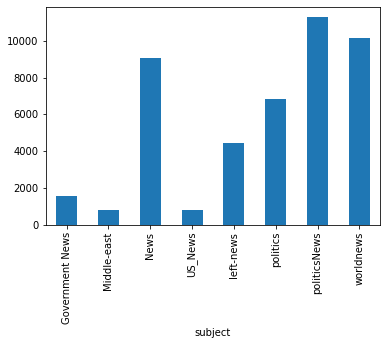

In [47]:
# How many articles per subject?
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64


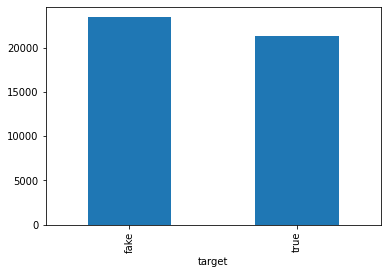

In [48]:
# How many fake and real articles?
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

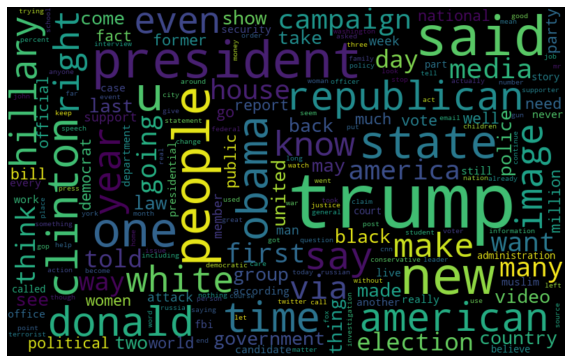

In [49]:
# Word cloud for fake news
from wordcloud import WordCloud

fake_data = data[data["target"] == "fake"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

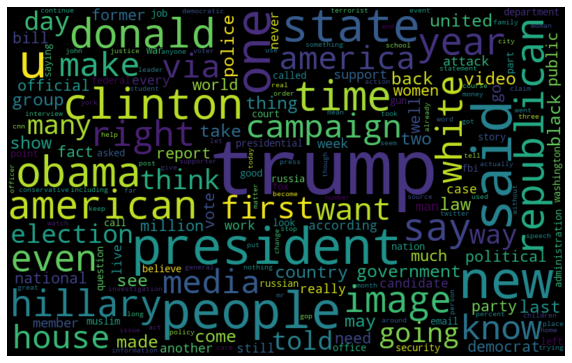

In [50]:
# Word cloud for real news
from wordcloud import WordCloud

real_data = data[data["target"] == "true"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [51]:
# Most frequent words counter (Code adapted from https://www.kaggle.com/rodolfoluna/fake-news-detector)   
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

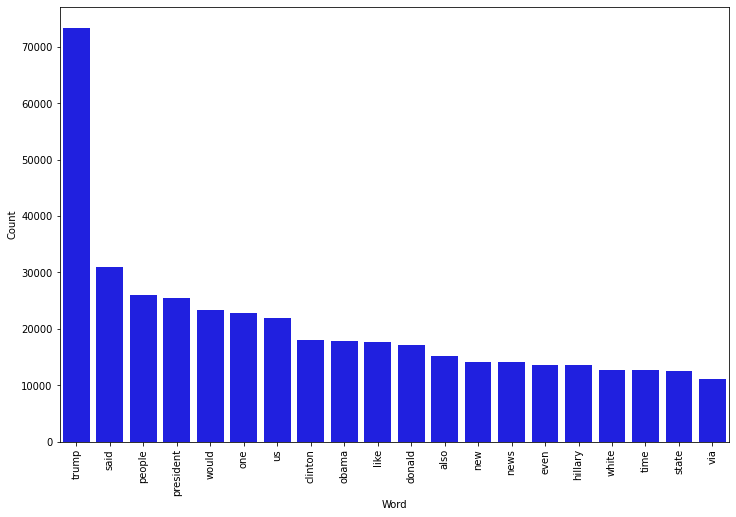

In [52]:
# Most frequent words in fake news
counter(data[data["target"] == "fake"], "text", 20)

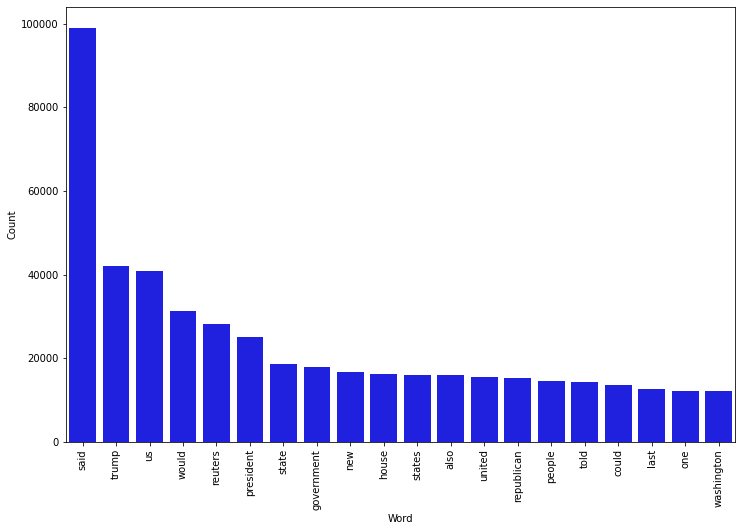

In [53]:
# Most frequent words in real news
counter(data[data["target"] == "true"], "text", 20)

## Modeling

In [54]:
# Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Peparing the data

In [25]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

### Logistic regression

In [26]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 98.72%


Confusion matrix, without normalization


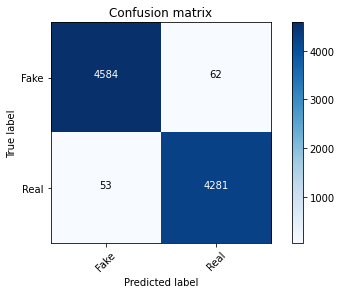

In [27]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

### Decision Tree Classifier

In [28]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.53%


Confusion matrix, without normalization


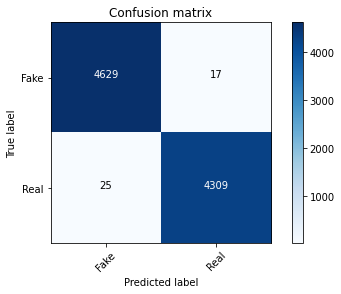

In [29]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

### Random Forest Classifier

In [30]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.02%


Confusion matrix, without normalization


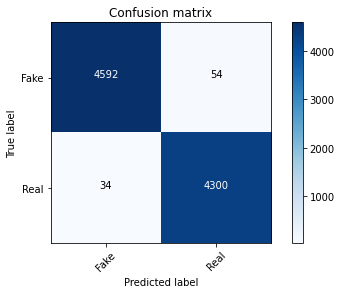

In [31]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])